In [24]:
import numpy as np
from libworm.model.beta_neuron import NeuronNetwork
import importlib
from matplotlib import pyplot as plt
import seaborn as sns

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

In [25]:
def setup(G_syn_value = 100.0, 
            G_gap_value = 100.0,
            G_leak_value = 10.0):
    _, trace, trace_labels, label2index, timestamps = traces.load_trace()
    timestamps = timestamps - timestamps[0]
    
    chemical, gapjn = connectomes.load_cook_connectome()
    neurons = connectomes.get_main_neurons(chemical, gapjn)
    neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)
    model = from_connectome(chemical,
                            gapjn,
                            neurons,
                            V_value=-60.0,
                            G_gap_value=G_gap_value,
                            G_syn_value=G_syn_value,
                            G_leak_value=G_leak_value)
    
    cell = "SMBVR"
    
    not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
    not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]
    
    removal = list(set(not_in_main_section).union(not_labelled))
    
    trace = np.delete(trace, removal, axis=0)
    
    trace_pairs = [(time, trace[:, i]) for i, time in enumerate(timestamps)]

    return model, trace_pairs, neurons

In [2]:
V = np.array([-40.0, -40.0])
G_syn = np.array([[0.0, 100.0], [100.0, 0.0]])
G_gap = np.array([[0.0, 0.0], [0.0,0.0]])

net = NeuronNetwork(V, G_syn, G_gap, v_clamp=np.array([0, 1]))

In [6]:
net.simple_run(0.001, 3.0)

##########

## Synapse loop

In [14]:
%%timeit
volts = np.array([40.0, -40.0])
syn = np.array([[0.0, 50.0], [80.0, 0.0]])
gap = np.array([[0.0, 100.0], [100.0,0.0]])
sim = an.NeuronNetwork(volts, syn, gap)
sim.simple_run(0.001, 30.0, show_progress=False)
#sim.show_all_data()

1.71 s ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Synapse x Voltage response

In [29]:
simulations = []

for j in range(1, 20, 4):

    results = []
    for i in range(0, 300, 20):
        volts = np.array([-200.0 + i, -40.0])
        
        syn = np.array([[0.0, 100.0], 
                        [j * 100.0, 0.0]])
        
        gap = np.array([[0.0, 0.0], [0.0,0.0]])
        
        sim = NeuronNetwork(volts, syn, gap, v_clamp=np.array([0, 1]))
        
        sim.simple_run(0.01, 10.0, show_progress=False)
        results.append(sim.syn_store[-1][0])
    simulations.append(results)
        


In [30]:
sum = 0
for j in range(len(volts)):
    sum += syn[:, j]
sum

array([ 100., 1700.])

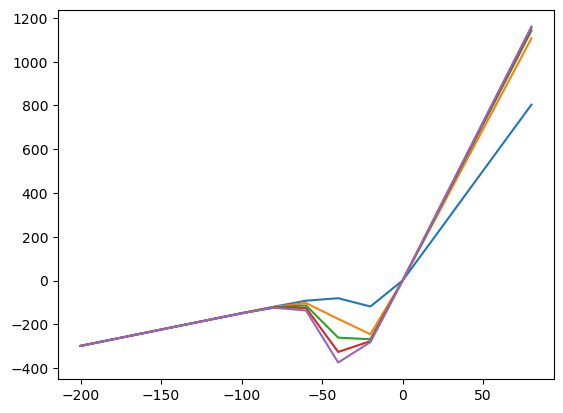

In [31]:
volts_x = [-200.0 + i for i in range(0, 300, 20)]
for sim in simulations:
    plt.plot(volts_x, sim)
plt.show()

## Gap Jn Voltage Response

In [8]:
simulations = []

for j in range(1, 20, 2):

    results = []
    for i in range(0, 300, 10):
        volts = np.array([-200.0 + i, -40.0])
        syn = np.array([[0.0, 0.0], [0.0, 0.0]])
        gap = np.array([[0.0, j * 100.0], [j * 100.0,0.0]])
        sim = an.NeuronNetwork(volts, syn, gap, v_clamp=np.array([0, 1]))
        sim.simple_run(0.001, 3.0, show_progress=False)
        results.append(sim.gap_store[-1][0])
    simulations.append(results)
        

KeyboardInterrupt: 

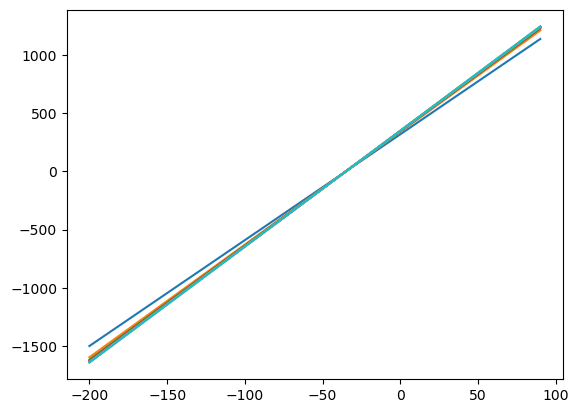

In [38]:
volts_x = [-200.0 + i for i in range(0, 300, 10)]
for sim in simulations:
    plt.plot(volts_x, sim)
plt.show()

# Numeric Stability

In [43]:
results = []
deltas = [0.2, 0.01, 0.0001]
I_gen = lambda t : np.array([0]) if t < 2.0 or t > 3.0 else np.array([50])
for delta_t in deltas:
    volts = np.array([-60.0])
    gap = np.array([[0.0]])
    syn = np.array([[0.0]])
    sim = NeuronNetwork(volts, gap, syn)
    sim.adv_run(delta_t, 5.0, I_gen, limiter=False)
    results.append([sim.t_store, sim.V_store])

#################################

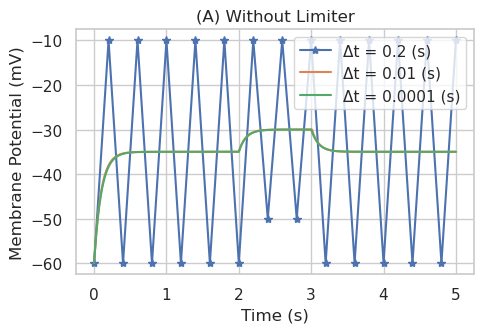

In [44]:
sns.set_theme(style="whitegrid")
shapes = ['*', '', '', '']

for i, res in enumerate(results):
    plt.plot(res[0], res[1], label=f"Δt = {deltas[i]} (s)", marker=shapes[i])
plt.legend(loc='best')

plt.title("(A) Without Limiter")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (mV)")

fig = plt.gcf()
fig.set_size_inches(5, 3.5)
plt.tight_layout()

plt.savefig('img/numeric_without_limiter.png', dpi=150)

In [45]:
model, data, neurons = setup()
model.adv_run(0.001, 5.0, I_gen, limiter=False)


#

/home/owner/Projects/the_worm_project/libworm/model/beta_neuron.py:63: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1.0 + np.exp(-beta * (V_m - V_th)))
/home/owner/Projects/the_worm_project/libworm/model/beta_neuron.py:44: RuntimeWarning: overflow encountered in multiply
  return V_m * co - int
/home/owner/Projects/the_worm_project/libworm/model/beta_neuron.py:38: RuntimeWarning: invalid value encountered in multiply
  sum += big_G_gap[:, j] * big_V[j]
/home/owner/Projects/the_worm_project/libworm/model/beta_neuron.py:28: RuntimeWarning: invalid value encountered in multiply
  return V_m * co - int


#########

### With Huge Current

##################################################

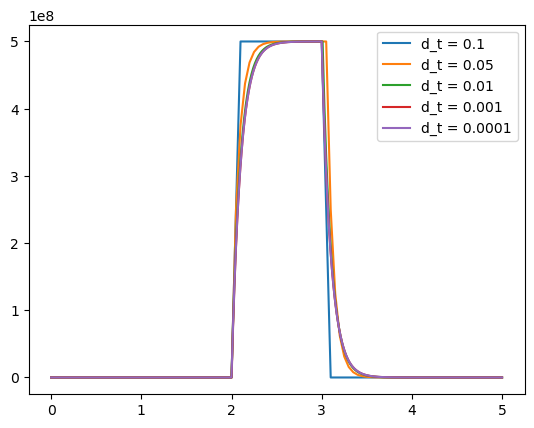

In [10]:
results = []
deltas = [0.1, 0.05, 0.01, 0.001, 0.0001]
I_gen = lambda t : np.array([0]) if t < 2.0 or t > 3.0 else np.array([5000000000])
for delta_t in deltas:
    volts = np.array([-60.0])
    gap = np.array([[0.0]])
    syn = np.array([[0.0]])
    sim = an.NeuronNetwork(volts, gap, syn)
    sim.adv_run(delta_t, 5.0, I_gen)
    results.append([sim.t_store, sim.V_store])

for i, res in enumerate(results):
    plt.plot(res[0], res[1], label=f"d_t = {deltas[i]}")
plt.legend(loc='best')
plt.show()